# phenotype prediction case study

The humble fruit fly, *Drosophila melanogaster* is one of the most important and well-studied model organisms in biological and biomedical research.

Early research using the fruit fly helped to establish the basic 'rules' of genetics and inheritance, including generating basic information about how mutations occur.

The fruit fly has been used extensively to learn about neural biology, including neurodevelopment and how neurological disorders important for human health occur, like Alzheimer's and Parkinson's.

The close historical association between fruit fly and human populations led to the use of the fruit fly as a model for studying early human migrations, including understanding how humans may have adapted to their local environments as they migrated out of Africa to colonize the globe.

The fruit fly was one of the first animals used to extensively study the links between genetic variation and differences in phenotypes at a whole-genome scale. In 2012, a public data-bank of ~200 'reference' fly lines were fully genome-sequenced and made available for use in a wide variety of genome-phenotype association experiments, with the results of all experiments made freely available to the public through the Drosophila Genetics Reference Panel (DGRP), now at the [dgrp2 website](http://dgrp.gnets.ncsu.edu/).

In this exercise, you will develop a neural-network model for predicting a fly's 'longevity' (normalized lifespan) from >17,000 genomic mutations ("Single Nucleotide Polymorphisms" or SNPs) dispersed along the fruit fly's two main autosomal chromosomes.

## data download and organization

The genomic SNP data and associated longevity phenotypes are available for 182 fly lines from the DGRP. We have made a copy of these data available in comma-separated value (.csv) format for this course.

Comma-separated value format is a very simple text file format, in which all the SNPs from a single individual or "line" are stored as a "row" of data, along with the line's identifier and the associated longevity value, which was measured experimentally. Each data field (column) is separated by a comma delimiter (",").

Comma-separated value files are widely used to store a variety of biological and other data. Microsoft Excel will export .csv files, and there are existing libraries that can be used to read and write .csv files to and from Python, R and other programming languages.

Reading data into a programming language environment is an important part of "data engineering" processes, which can also include data normalizations and transformations, filtering based on quality and other attributes, and setting up efficient pipelines to move your data from disk or main computer memory onto the GPU for neural network training.

This course doesn't focus on data engineering, and you won't have to write any data parsing code in this class. However, you should have a very basic understanding of some of the main tools used to get your data from a text file into a format that can be used for neural network training.

### importing .csv data using pandas

Fortunately for us, we don't have to write the code to parse the .csv data file. We'll use the "[pandas](https://pandas.pydata.org/)" python library to parse the data file for us.

We'll need to import the "pandas" library, which can be done by including an:

    import pandas

directive at the top of the following code cell.

Then we can use the:

    pandas.read_csv(URL)

function to read the .csv data file found at "URL" into a "dataframe" object.

The "URL" or "Uniform Resource Locator" is used to specify the location of the .csv data file. If this file were located on your local computer, the URL would be the name of the file on your machine. In this case, the data file is available on the internet at [https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv](https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv) (clicking on the link will show you that you would *not* want to have to read this file!). We can supply the internet location directly to pandas, and it will read the file for us and package its contents into a python object called a pandas.DataFrame. In the following code cell, we're capturing the pandas.DataFrame object in a variable called "dataframe", so we can use it later.

We'll print the first 5 lines of the dataframe object using the:

    dataframe.head()

method call, so we can see what the data file looks like without having to read through all 182 rows and >17,000 columns of data.

In [ ]:
import pandas
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
dataframe.head()

As you can see from the output of the "dataframe.head()" method call, the file has 17,167 columns of data in each row, and we are showing the first 5 rows of data.

The pandas library numbers each row of data, starting at zero; you can see these numbers along the left-hand side of the code cell output. These are sometimes called the "row header".

Along the top of the code cell output, you will see the "column header", which lists the 'names' or "labels" of each of the columns. The first column is labelled "SID", which stands for "Sequence IDentifier". The first sequence identifier is "S0", the second is "S1", and so on.

Coincidentally, the sequence identifers *happen* to match the row identifiers, but this is not typically the case. Importantly, the sequence identifiers are *part of* the original .csv data file, while the row ids are *added* by the pandas library to the data frame and are *not* part of the actual data.

After the SID colum, you'll see a *bunch of* column labels starting with "SNP", followed by a number. These are the Single Nucleotide Polymorphism (SNP) identifiers. Each location in the genome gets a specific identifer, so the SNP0 entry for sequence S0 corresponds to the *exact same location in the genome* as the SNP0 entry for sequence S1, S2, etc. That way, it is possible to compare SNPs across sequenced fly lines.

In these data, SNPs are encoded as *binary* character data. Each SNP is either a 0 (indicating the 'reference' allele) or a 1 (indicating the 'alternative' allele). This is the *simplest* way to encode SNP data.

To understand SNPs a bit better, we need some basic information about the genome. An organism's genome consists of the nucleotide bases A,C,G and T, arranged sequentially and packaged into chromosomes. Many organisms have two copies of each chromosome (they are "diploid"), but we can ignore that for now. There are also two *complementary* strands of DNA in each chromosme, but we can ignore that, as well, because if we know the sequence of one strand, then we *automatically* know the corresponding sequence of the other strand (A pairs with T, and C pairs with G).

So we can 'abstract' an organism's genome into a 'string' or sequential sequence of the 'letters' A,C,G and T. An organism's genome is "sequenced" when we have experimentally determined the entire string of As,Cs,Gs and Ts for that organism's genome.

Typically, the "reference genome" is just the first genome from a certain species that was sequenced. There is nothing 'magical' that makes a specific genome the "reference"; it was just the first one that was sequenced. The current "reference" genome for *Drosophila melanogaster* can be found [here](https://www.ncbi.nlm.nih.gov/genome/47) at the National Center for Biotechnology Information (NCBI). It is also maintained by the [FlyBase](https://flybase.org/) consortium.

For each DNA base position in the reference genome, the letter at that position defines the "reference allele". So, if the "reference genome" has an "A" at position 204,603 on chromosome 2L, then the "reference allele" at that position is "A". Again, there is nothing inherently 'biologically relevant' about the "reference allele"; it is just the specific letter that happened to be at that position when the *first* (or "reference") genome from that species was sequenced.

When we sequence the genome of a *new* fly line, we can compare the new fly's genome to the "reference" at *every* position (more or less). If the new genome has the *same letter* as the "reference" genome at a specific position, then the new genome has the "reference allele" at that position, and the SNP is encoded as "0". If the new genome has a *different* letter from the reference genome at a specific position, then the new genome has an "alternative allele", and the SNP is encoded as "1".

Of course, there are some 'wrinkles' that can come up. For example, what if there are *two different possible* alternative alleles? For example, what if the reference allele at a position is A, one of the fly lines has a C at this position, and another fly line has a G? These "tri-allelic" (or, more generally, "multi-allelic") SNPs do exist, but they are much less common than typical "bi-allelic" SNPs, which can be coded as either zero or one. Most studies ignore SNPs that are not bi-allelic, although there are examples of studies that do consider them. In this case, we're ignoring non-bi-allelic SNPs, so *all* our SNPs can be encoded as either 0 or 1.

Another potential *major* problem is that many organisms are "diploid" - they have 2 copies of each chromosome and therefore 2 alleles at *every* position in the genome. So, technically, each line *could* have any of the following:

* reference alleles on *both* chromosomes (which could be coded as "00")
* reference allele on *one* chromosome and alternative allele on the other ("01" or "10)
* alternative alleles on *both* chromosomes ("11")

This is common in fly (and human) populations; we can be "heterozygous" ("01" or "10") at *many* positions in the genome. Many studies deal with this possibility by encoding SNPs as 'tri-nary' data, either:

* 0 - reference allele on both chromosomes
* 1 - reference allele on one chromosome and alternative on the other
* 2 - alternaive allele on both chromosomes

In our case, these fly lines have been 'inbread' to be homozygous at (nearly) *all* positions in the genome, so we can ignore heterozygosity in this case. Many mouse lines used in biomedical research have also been 'inbread to homozygosity'. A *major* benefit to using "inbread lines" in research is that it facilitates replication and comparison, both within and across different studies. A major *downside* to inbread lines is that they are no longer representative of the *natural population* of the organism; most flies (and humans) 'in the wild' are highly heterozygous!

Conceptually, we are using SNPs (which we can measure experimentally for *any* individual organism) to measure the variation in an individual's genome at an *extremely high* resolution, perhaps the *highest* resolution possible for genomic DNA (Although DNA modifications can also alter genome function. They are inherited but change over an individual's lifespan. Somatic mutations definitely impact function, but are not inherited.).

We are using 17,165 binary-encoded SNPs from chromosomes 2L and 3L to characterize "genomic variation" across these 182 inbread lines of the fruit fly, *Drosophila melanogaster*.

We can verify this by looking at the "shape" of the pandas.DataFrame object.

In [ ]:
dataframe.shape

There are 182 'rows' in the dataframe, one for each of the inbread lines (SIDs "S0, S1, S2, ..., S181). Pandas does *not* include the column header in the dataframe's shape, so the first rank of the dataframe's shape indicates the number of *data rows* in the table.

There are 17,167 columns in the dataframe. But are there 17,167 **SNPs**?

Pandas doesn't attach any *meaning* to the data in the dataframe it creates; it just *reads* the data into a matrix (2D tensor) and associates it with column and row header names.

In itself, this is *really* useful, but it isn't ready for neural network analysis.

## train-validate data split without 'looking at' the data

First of all, we *know* that we are going to need training and validation data sub-sets, so we can validate our neural-network's performance in a reasonable way. In particular, we'll *at least* need to evaluate overfitting, so we need to divide our data. We might also do a 3-way train-validate-test split; we would *need* this 3-way split if we want to do *any* comparison across *different* models. In practice, we would almost *always* do a 3-way split. For this exercise we're only doing a 2-way 'train-validate' split.

Whether you choose to do a 2-way or a 3-way data split for a particular analysis, you must *always* split your data into sub-sets *first*. This is a *best practice* strategy to to avoid 'accidentally' using any property inferred from the data to inform your split, which would invalidate any down-stream analysis you might want to perform. From a practical point of view, it invalidates the neural network training procedure, so the trained network is statistically 'useless'.

The Pandas library has a method to randomly extract a subset of rows from a dataframe. We'll use the:

    dataframe.sample(frac=X)

method call on our pandas.DataFrame object to extract 80% of the data 'randomly' for neural network training. We do this *before* ever looking at the data, to make sure there is *no way* we could have inadvertently measured something about the data *before* the split. Because we haven't measured *any* properties of the data (we read the shape of the data frame to confirm it was complete, but we know nothing about the data, itself, except for what they 'mean' conceptually), we can't possibly *use* any properties of the data to inform the data split, so our down-stream analyses are not statistically invalid, assuming the 'validity' of the original data file, the network transfer of that file, the reliability of the pandas library, etc).

We'll set the "frac" option to 0.8, to use 80% of the data for network training. We'll also set the:

    random_state=RNS

option, so we can reproduce our exact results, should we need to for debugging or other purposes. In this case, we use:

    random_state=402201

But the number can be any moderate integer. You could even use the date you wrote the number in. Don't change it in the code cell for now, or your results might not match those coded in the quiz! But *after* you take any quiz associated with this notebook and are happy with your results, *then* you can feel free to play around with different random "seeds", and see how 'sensitive' your results are to changing the random seed. If you had a network that was *very* sensitive to different random state seeds, would you be more or less 'confident' in the results?

We'll capture the training data in a new pandas.DataFrame object, so we can keep all the row and column header information. We call this training dataframe "train_dataframe" in the following code cell; the name is arbitrary (to python) but conveys some information to the human user.

We also need to put all the data *not* in the training dataframe into the validation dataframe (which we call "valid_dataframe").

We'll do this by extracting *all* the "indices" of the training dataframe, and *dropping* all those values from the *original* dataframe, effectively 'taking' the training data 'out of' the original dataframe, but in two steps:

1.  copy a randomly-selected 80% of the rows in the original dataframe to a new datafrane (called "train_dataframe")
        train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
2.  remove the training data from the original dataframe, based on the data row indices in the training_dataframe), and store the result under a new variable name, "valid_dataframe")
        valid_dataframe = dataframe.drop(train_dataframe.index)

Now we have split our data into 2 random sub-sets, "train_dataframe" and "valid_dataframe", without measuring any properties of the data or even 'looking at it' at all; everything was done inside the pandas library.

We can print the shapes of the sub-sets to verify they were split approximately 80%-training and 20%-validation. If you use the *same* random_state, you should get *exactly* the same results. Changing the random_state to something else will give you *different* results, but *both* results should be a 'statistically valid sample', albeit only a *single* sample from random_seed 'space'.

We can remedy this "N=1" problem (relying on a *single* sample to infer information about the *distribution* of outcomes) by running our *entire* analysis *multiple* times, with *different* ranom seeds. For this exercise, we'll just set a reproducible seed and run it once.

In [ ]:
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

We can see from the print(...) function call that there are 146 data rows in the "train_dataframe", each consisting of 17,167 columns of data. The "validation_dataframe" has 36 rows and 17,167 columns. And we print the original dataframe's shape, for comparison; there are 182 rows of data in the original "dataframe", with 17,167 columns.

The numbers of columns *all* match, so that's good; we haven't 'lost' any columns, and all the data sets have the same rank (2).

The number of rows in the training and validation dataframes add up to the number of rows in the original dataframe, suggesting we probably have a nice *partition* of our data, although we can't confirm this for sure unless we 'look at' the data to make sure *all* of the SIDs only occur *once* in *both* datasets. We won't do that here.

    146 + 36 = 182

Which is consistent with a partitioning data split.

The proportions are 'about' what we asked for: 80% training, 20% validation:

    146 / 182 = 0.802
     36 / 182 = 0.198

So, we conclude that we probably have a 'good' train-validate split, but without 'looking at' any of the data.

## extracting explanatory variables (aka 'getting our SNPs'), and associated response variables without 'looking at' the data

If you 'scroll back' through the dataframe.head() output, you can see the column headers for *all* the SNP columns start with "SNP", followed by a number.

This can be reproduced 'without looking at the data' by looking at *only* the column headers of the original dataframe.





In [ ]:
dataframe.columns

This shows an "Index" object 'pointing into' our data, but it doesn't show us the data!

The 'SID' entry is our unique sequence identifier. There is a long list of 'SNPXXX' header entries, where 'XXX' is an integer, starting at "0" and ending at "17164"; they are sequential in this case, but not always!

The final column is called "LS"; this is our *response* variable, the "Longevity Score".

The column headers can be made public, and they *should be* documented, ideally to 'programmatic detail' - ie, in source code. For this exercise, we can communicate in this notebook (which includes runnable source-code!) the semantics of the explanatory- and response-variable encoding in the dataframe column headers.

We can extract *all* the explanatory variables by selecting any dataframe.column that starts with the string 'SNP'.

We'll use a 'list comprehension' to do that in python. You don't *need* to know how list comprehensions work in this course; they're used here as part of a "data engineering" pipeline and not really for developing the 'AI'.

But if you are interested, you may read on...

The list comprehension applies a "conditional":

    if x.find('SNP') == 0

to *each* element "x" in the dataframe's 'Index' of columns:

    for x in dataframe.columns

Transforms the element in an arbitrary way (in this case, we just return the *untransformed* element:

    x

And we package the result in a python list called "snp_ids":

    snp_ids = [ ... ]

The 'specific' conditional we are using:

    x.find('SNP')

returns 0 if the string "SNP" is found in the element x *at the first position*, so we grab 'every column header value' that 'begins with' "SNP".

In [ ]:
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
snp_ids[:5]

Here we print only the first 5 SNP identifiers to the screen.

    snp_ids[:5]

Returns a 'slice' of the snp_idx list, starting at index zero, and going up to *but not including* index 5.

So "snp_ids" is a list of *all* the column headers of the SNP data (ie, 'explanatory variables').

We'll extract *just* the explanatory variables of the training data to a numpy array "train_x", with the "x" indicating to the human user that these are the explanatory variables, and the "train" indicating that they are from the training data.

    train_x = train_dataframe[snp_ids].to_numpy()

We'll use numpy to 'translate' between the pandas.DataFrame object and the tensorflow.Dataset we'll need to train our neural network. Numpy is great for this, as *most* libraries will read/write numpy.

We do the same thing with the 'SNP' data from the validation data subset, storing the explanatory variables from the validation_dataframe in a new variable called "valid_x" - the validation data's explanatory variables.

We can check the shapes of these numpy arrays, again without 'looking at' the data.

In [ ]:
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

The number of 'rows' is consistent: 146 in the train_x, and 36 in the valid_x numpy arrays; same as in the dataframe split.

And now there are 17,165 columns, which is the same in both train_x and valid_x.

All the columns in the data file are 'SNP' data, except for 2 of them, the "SID" (unique Sequence IDentifier), and the "LS" column, which stores the 'Longevity Score' associated with that SID.

In python, we extract the 'LS' columns from train_dataframe and valid_dataframe, to partition the longevity scores (aka, "response variable") into training and validation data sets that correspond to the explanatory variables in order. This separates the explanatory variables from the corresponding response variables, but we won't change the order. We're relying on the pandas library to keep data ordering consistent between data requests, even when converting to numpy. We're also relying on numpy to maintain ordering.

In [ ]:
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

Now we have the following variables:

    train_x  # training data explanatory variables
    train_y  # training data response variable
    valid_x  # validation data explanatory variables
    valid_y  # validation data response variable

Let's use these numpy arrays to create tensorflow Dataset objects for neural network training.

## packaging tensorflow Datasets for training and validation

We need tf.data.Dataset objects to train our neural network in tensorflow.

Fortunately, we've seen the tf.data.Dataset before; we can create Dataset objects using the:

    tf.data.Dataset.from_tensor_slices(...)

Class method call to create a tf.data.Dataset object from a pair of numpy arrays holding the explanatory and response variables.

We'll also batch our tf.data.Dataset objects, using a batch size of 10 for the training data and 36 (ie, all of the validation data in one batch) for the validation data. Most large-scale studies use batch sizes in the range of 64-512 for *both* training and validation data. Our example has been intentionally made smaller to reduce computation time, so we're using much smaller batch sizes than normal, but it's easy to change that if needed.

In [ ]:
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)

Remember that, once our data goes into a tf.data.Dataset object, it is more difficult to inspect the size and shape of the data, so we aren't printing anything from the above code cell.

Now we have one "train_data" tf.data.Dataset object for our training data (built from train_x,train_y numpy arrays), and one for our "valid_data" (built using numpy arrays valid_x,valid_y).

That's it! We got our data from the original data file into tensorflow *without ever looking at the data*.

Our "data engineering" pipeline has not corrupted the statistical validity of the train-validate (or train-validate-test) data split, and we have not even *measured* any statistical properties of the data (other than the shapes of the tensors holding the data).

Once in tensorflow, we don't have to look at or measure anything about the data to train the neural network - the tensorflow library is relied upon to faithfully transfer the data to the neural network during training and validation (and testing).

We haven't 'looked at' the data, and we've documented this in runnable source code.

### end-to-end data engineering pipeline

The following code cell shows the entire data intake pipeline, from reading the data file to creating the tensorflow.Dataset objects.

In [1]:
import pandas
import tensorflow as tf

# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)


The print(...) statements cofirm the original dataframe has shape (print statement at line #6 in the code cell):

    (182, 17167)

We split it into training and validation subsets of sizes (print statement at line #11):

    (146, 17167) (36, 17167) ...

And the original dataframe's shape is unchanged:

    ... (182, 17167)

Training and validation explanatory variables have respective shapes (line #17):

    (146, 17165) (36, 17165)

We'll use these shapes later to specify the input shape of our neural network. We note that there are 17165 'explanatory variables', so the input_shape of the first layer of our neural network should be:

      input_shape=[17165]

when we create it.

Finally, the shapes of our 'response variables' for training and validation data sets are respectively (line #22):

    (146,) (36,)

The response variable is rank-1 and 1-dimensional, so we will need a single Dense neuron for the neural network's output layer, which is by far the most common case.

In general, if using a Dense neural-network output layer, the number of "units" in the output layer is made to be the same as the dimension of the response variable.

The vast majority of neural networks at the time of this writing use a single Dense neuron as the output layer. Almost all 'classifiers' do this (typically with "softmax" activation), and many regression networks use a single-neuron Dense layer with linear activation as the output layer.

Other types of neural network Layer objects might have to be specified differently when used in the output layer, in order to match the rank and dimension of the response variable. The 'first' rank of the response variable can be ignored, this will be filled in by tensorflow as the 'batch' rank of dimension "None". But the network's output shape *must match* the shape of the response variable (excluding the number of 'rows').

There are twenty-six lines of code in our data intake protocol, which is comparable to the ~36 lines of code we've been using to create, train and validate neural network models in previous exercises. We now have the:

    train_data
    valid_data

tensorflow Dataset objects. We will use those later to fit and validate our model.

We've hard-coded a few things, which could be made into global variables at the top, or provided by the user in a python script, but we've documented them in this notebook, so we're good.

It's pretty common for a data-intake pipeline to be a similar amount of 'lines of code' as a neural network analysis, using data minipulation libraries like pandas and numpy.

We haven't included *any* data quality control; we are relying on the accuracy, reliability and integrity of the data file at the specified URL. But our entire analysis is completely agnostic to whatever data is in that file; we have *never* 'looked at' the data.

## building the neural network model (without 'looking at' the data)

Now that we have our training and validation data in different tf.data.Dataset objects, we can build our Sequential neural network model.

We'll start by evaluating a simple linear model of our data.

The linear model makes the assumption that there is an *additive* relationship between the explanatory and response variables, that they lie along a 'straight line' in a very *high* diensional space.

How "highly" dimensional does our model need to be?

It needs to be the *same* dimensionality as the input data! Specifically, the shape of the neural network's input needs to be the *same* shape as the shape of the explantory variables, without considering the 'batch' dimension (number of rows in the dataset).

There are 17165 explanatory variables in our data set. We know this from the shapes of the "train_x" and "validate_x" numpy arrays. So the dimensionality of the input data space is 17165-dimensional.

We know that the response variable is a rank-1 tensor of 1 dimension, so we can implement a simple linear model using a Sequential model holding a single-neuron Dense layer.

Fill in the following code cell where it says "FIXME", between the:

    ### BEG BUILD AND COMPILE MODEL

and:

    ### END BUILD AND COMPILE MODEL

to add your neural network Layer objects to the existing tf.keras.models.Sequential object stored in the "model" variable.

**And** compile your model using the:

    tf.keras.optimizers.SGD

optimizer, and the:

    tf.keras.losses.MeanSquaredError

loss.

You should see a summary of the model. Make sure the model's input and output shapes match those of the explanatory and response variables in the data set.


In [13]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1,  input_shape=[17165]))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Your model should have 17,166 trainable parameters, one 'slope' for each of the SNPs (17,165), plus a single bias term.

    y = MX + b

A linear model in 17,165-dimensions. In the linear equation, upper-case letters represent tensor variables of the *same* dimension, and lower-case letters indicate rank-1 1-dimensional tensors (ie, "scalars").

## fit and validate your model

Now we have a model and a dataset, both in forms that can be used in tensorflow.

So long as the model's shape matches the dataset's shape, it should fit without any (error) problems.

The following code cell replicates the end-to-end exercise, including the data intake pipeline we implemented first as a 'data engineering' exercise (and because we needed to get the data into tensorflow without 'looking at' it for the analysis to be statistically valid!).

You will need to copy your model implementation from the previous code cell, but other than that this cell should run okay, even if you disconnect from the jupyterhub's runtime instance and lose the state of the page.

Try it and see what happens (hint...).

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 1s 17ms/step - loss: inf - val_loss: inf
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: nan - val_loss: nan
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: nan - val_l

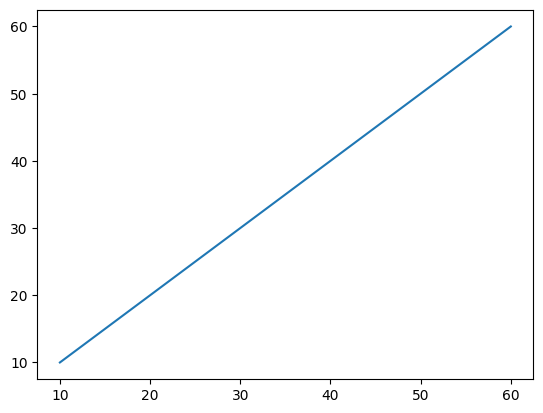

In [6]:
import pandas
import tensorflow as tf

### BEG DATA INTAKE
# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)
### END DATA INTAKE

### BEG NEURAL NETWORK TRAIN-VALIDATE
## build and compile linear neural-network model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1,  input_shape=[17165]))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

## fit and validate neural-network model
model.fit(train_data, epochs=100, validation_data=valid_data)
### END NEURAL NETWORK TRAIN-VALIDATE

### PLOT RESULTS FOR VISUALIZATION
## predict training and validation responses for plotting
train_y_hat = model.predict(train_x)
valid_y_hat = model.predict(valid_x)

## plot true-vs-predicted responses
import matplotlib.pyplot as plt
plt.plot([10,60],[10,60])
plt.scatter(train_y, train_y_hat, marker='o')
plt.scatter(valid_y, valid_y_hat, marker='+')

If all goes well with the model implementation, you should see the familiar epoch-by-epoch report scrolling by as tensorflow trains the model.

But, you might notice that "loss" and "val_loss" are being reported as "nan" from tensorflow. That's odd.

If you see the plot, you'll notice a blue diagonal line, but nothing else! Something appears to be wrong. But we'll get to that in a bit.

### common errors

If you *don't* see the "nan" values, epoch-by-epoch report and blank plot, then there is likely something *wrong* with the model implementation, which needs to be fixed.

The *first* thing to check is the error message that is reported; the actual output of the code cell, even though it is reporting an error.

Error reports can be highly variable and depend on the specific error. Program error reports are also typically written 'for programmers' and can be quite challenging to decipher. Because tensorflow is built for speed, the actual error might not be identified until the graph starts to run on the GPU. Other errors might be caught earlier.

The thing to look for in the error report is if there are *any* lines in the error report that refer to any *specific* lines in the code cell. If you are lucky, you'll see a list of line numbers along the left-hand side of the error report. These refer to the line numbers in the code cell that created the error (turn line numbering on in colab settings, if you haven't!). There should be a 'big arrow' pointing to the line of code where the python interpreter identified an error. This is not *always* the *exact* line of code that *produced* the error, but it should be close (and there are only ~58 lines of code in the code cell, and only a handful for creating the model).

The most common programming errors in tensorflow are almost *always* either

*  simple typos, or
*  errors in input/output shapes

So I check for mis-spelled variable names or commas-instead-of-periods, missing-parentheses types of errors first. If you are unsure about the python syntax used to create a single-neuron implementation of a simple linear model, please review the previous jupyter notebooks used in this course for examples; they should provide *exact* syntax and pointers on how to specify or change specific attributes of the model like input and output shapes.

Getting all the network layer shapes to fit with one another, and with the input data, can be error-prone in general, particularly if you are doing complex data manipulations as part of your model. For the simple linear model, we only need to match the input shape to the data.

If the model's input shape is mis-specified, you will likely get an error when you call:

    model.fit(...)

Which is likely to be around line #41 in the code cell.

However, the *actual* error is likely to be in the specification of the model's

    input_shape

when the Layer object is added to the Sequential model object. This is likely to be around line #34 in the code cell. Check that your model's input shape matches the number of SNPs!

Failing to compile the model can also cause some errors. These will *also* be identified by tensorflow when the model.fit(...) call is made (around line #41). But in this case, you should see:

    RuntimeError: You must compile your model before training/testing.

at the end of the error report. If you forget the:

    model.compile(...)

method call, or it is in the wrong place, you will get an error like this.

Make sure you diagnose and fix any program errors and can fit your model in the previous code cell, before continuing.

## so my model fits, but "nan" is not a useful loss value

Now that the model fits 'correctly', we can deal with the problems of "nan" loss values and nothing in our correct-vs-predicted response plot!

We chose to use "MeanSquaredError" loss to train and evaluate our model. This was working well before and is commonly used in linear regression.

But what happens if the loss is *very* large, like what might happen if we start the fitting process with a 'random' line through our data *without even looking at the data*?

When you *square* a large number, it gets *much* larger. Perhaps if the loss were *really bad* when the network is 'randomly initialized', the Mean**Squared**Error loss might get *too big* to fit in the GPU's finite memory.

This is sometimes called an "overflow" error. An "overflow error" occurs whenever the result of a computation becomes *too large* (or too small, which would be an "underflow error") to fit in the variable storing it. In these cases, tensorflow reports "nan" as the loss, which does *not* supply the gradients needed to fit the model using backpropagation.

We could try to 'start' our network from a 'better' place, so that the loss *never* gets too large, but we'd probably have to 'look at' the data to find a 'better' starting place.

Instead, let's use a *similar* loss function that *doesn't* get 'too large' when randomly initialized.

In this case, we can use:

    MeanAbsoluteError

loss. While Mean**Squared**Error multiplies the difference between the true and predicted response values *by itself*, we could also take the *absolute-value* of the difference between true and predicted responses, to avoid overflow.

Tensorflow implements MeanAbsoluteError as a:

    tf.keras.losses.MeanAbsoluteError

object.

Switch the loss to "tf.keras.losses.MeanAbsoluteError" in your "model.compile(...)" method call, to use the more appropriate loss function.

For convenience, the end-to-end example is reproduced in the code cell below; you'll have to copy your model implementation, but make sure to change the loss function. Keep everything else unchanged. In general it's best to make only a single change at a time, so that each change can be independently evaluated.

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 1s 19ms/step - loss: 10.1217 - val_loss: 6.7194
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 6.3244 - val_loss: 5.7854
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 8.6526 - val_loss: 7.2594
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 7.8928 - val_loss: 10.0423
Epoch 5/100
15/15 [==============================] - 0s 9m

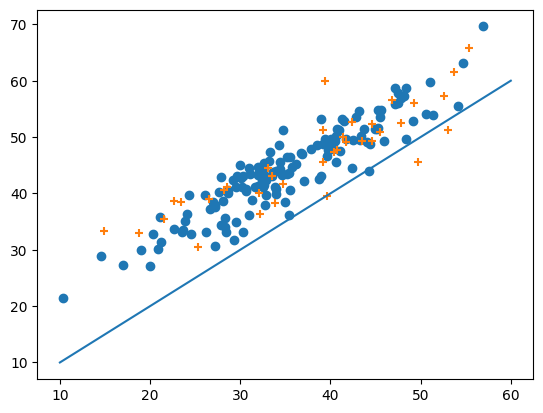

In [7]:
import pandas
import tensorflow as tf

### BEG DATA INTAKE
# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)
### END DATA INTAKE

### BEG NEURAL NETWORK TRAIN-VALIDATE
## build and compile linear neural-network model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1,  input_shape=[17165]))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanAbsoluteError())
model.summary()

## fit and validate neural-network model
model.fit(train_data, epochs=100, validation_data=valid_data)
### END NEURAL NETWORK TRAIN-VALIDATE

### PLOT RESULTS FOR VISUALIZATION
## predict training and validation responses for plotting
train_y_hat = model.predict(train_x)
valid_y_hat = model.predict(valid_x)

## plot true-vs-predicted responses
import matplotlib.pyplot as plt
plt.plot([10,60],[10,60])
plt.scatter(train_y, train_y_hat, marker='o')
plt.scatter(valid_y, valid_y_hat, marker='+')

Now we should see that we are getting sensible loss values (not "nan", at least!), and the plot should now look like it 'has some data' in it.

## evaluating model fitting problems

The plot should have a diagonal blue line across the middle, as before. This line represents what would be a "perfect fit" between true and predicted responses. It comes from plotting the true values against *themselves*.

The blue circles are the true responses (x-axis) vs the corresponding predicted responses (y-axis) from the fit model *on the training data*. This represents the "fit" of the model to the training data. We expect these data to lie "close to" the 'theoretically perfect' diagonal line, but to be 'spread out' around the 'perfect' line, due to statistical 'error' in the data and the model-fitting process. Blue dots *above* the diagonal line indicate training samples for which the predicted response is *greater than* the true response. Blue dots *below* the diagonal line indicate training samples for which the predicted response is *less than* the true response.

*Assuming* there *is* a linear relationship between expected and response variables, the predictions (blue dots) should be 'close to' the 'perfect' diagonal line. If not, either:

* the data do not follow a linear model, or
* the training process has not 'converged' to a 'near optimal' solution

Or both!

If the training data can't be 'well-fit' by a linear model, the true-vs-predicted plot (blue dots) is likely to be either *very* spread out across the graph, or to display some *pattern* that is *not* a straight line.

When I ran this analysis, the blue dots did 'appear' to be oriented along roughly the *same* slope as the 'perfect' diagonal line, indicating that they might be well-fit by a linear model. However, in my case the "y-intercept" appeared to be off - nearly *all* the predicted values were *above* the 'perfect' line. Because the model fitting process is 'stochastic', your results may be different from mine. Perhaps your 'blue dots' are clustered *below* the 'perfect' line, or perhaps they are oriented along a different slope.

This suggests we might need to train our model a little longer to allow it to identify more 'optimal' parameter values.

In the following code cell, change the number of epochs of training from 100 to a larger value of 500. As before, you'll have to copy your network building and compiling code. Everything else should be the same as before, and make sure to keep the MeanAbsoluteError loss function. This analysis will take about 5-times as long as the previous model fit.

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - 0s 9ms/step - loss: 10.1946 - val_loss: 7.8327
Epoch 2/500
15/15 [==============================] - 0s 3ms/step - loss: 6.6832 - val_loss: 4.4805
Epoch 3/500
15/15 [==============================] - 0s 3ms/step - loss: 7.2591 - val_loss: 7.3009
Epoch 4/500
15/15 [==============================] - 0s 3ms/step - loss: 7.0736 - val_loss: 7.5935
Epoch 5/500
15/15 [==============================] - 0s 3ms/

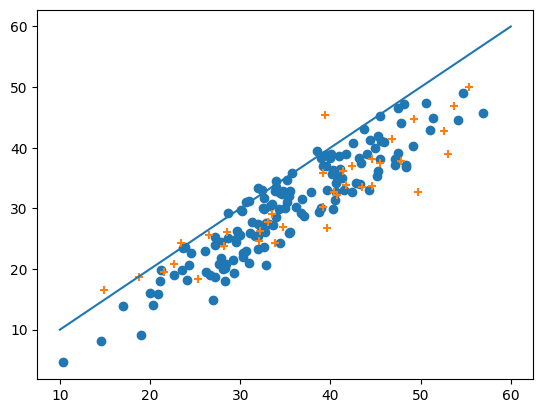

In [8]:
import pandas
import tensorflow as tf

### BEG DATA INTAKE
# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)
### END DATA INTAKE

### BEG NEURAL NETWORK TRAIN-VALIDATE
## build and compile linear neural-network model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1,  input_shape=[17165]))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanAbsoluteError())
model.summary()

## fit and validate neural-network model
model.fit(train_data, epochs=500, validation_data=valid_data)
### END NEURAL NETWORK TRAIN-VALIDATE

### PLOT RESULTS FOR VISUALIZATION
## predict training and validation responses for plotting
train_y_hat = model.predict(train_x)
valid_y_hat = model.predict(valid_x)

## plot true-vs-predicted responses
import matplotlib.pyplot as plt
plt.plot([10,60],[10,60])
plt.scatter(train_y, train_y_hat, marker='o')
plt.scatter(valid_y, valid_y_hat, marker='+')

At least when I ran it, increasing the number of epochs of training from 100 to 500 didn't seem to help the model's fit to the training data that much.

The blue dots were still primarily above the 'perfect' line. And the final "loss" value reported by tensorflow (loss on the training data) was similar to what it was with the shorter training run.

Perhaps there was a *small* improvement from longer training, but let's see if we can do a little better by using a more 'effective' optimizer.

Stochastic Gradient Descent (SGD) is a widely-used optimization algorithm, but it can sometimes perform poorly in very high-dimensional problems. We have 17,165-dimensional data! SNP data are also *binary* integers (0 or 1); discrete explanatory variables can generate complex 'curvatures' in the loss-function space, which can lead to problems converging to globally-optimal (or near-optimal) loss values.

If these problems are present in our analysis, using an "adaptive" optimizer might produce better (or at least 'different') results. If *all* optimizers produce the *same* results, we'd know that changing the optimizer *won't* help.

Change the optimizer in the following code cell to use the:

    tf.keras.optimizers.Adam()

optimizer. The [Adam](https://arxiv.org/abs/1412.6980) optimizer is a general-purpose optimizer that is widely used in neural network training. It uses quite a few 'bells and whistles' to help improve its effectiveness in optimizing loss functions in high dimensions, with large networks, and when the loss function is complex.

As before, you'll need to copy your network code, only changing the optimizer you use when compiling the model. Make sure to leave the training epochs at 500.

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - 0s 8ms/step - loss: 18.5534 - val_loss: 7.4579
Epoch 2/500
15/15 [==============================] - 0s 3ms/step - loss: 6.7964 - val_loss: 6.3942
Epoch 3/500
15/15 [==============================] - 0s 3ms/step - loss: 4.0501 - val_loss: 4.2602
Epoch 4/500
15/15 [==============================] - 0s 3ms/step - loss: 2.6848 - val_loss: 4.1028
Epoch 5/500
15/15 [==============================] - 0s 4ms/

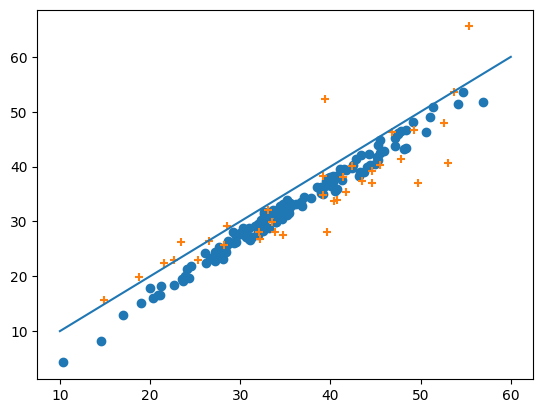

In [9]:
import pandas
import tensorflow as tf

### BEG DATA INTAKE
# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)
### END DATA INTAKE

### BEG NEURAL NETWORK TRAIN-VALIDATE
## build and compile linear neural-network model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1,  input_shape=[17165]))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanAbsoluteError())
model.summary()

## fit and validate neural-network model
model.fit(train_data, epochs=500, validation_data=valid_data)
### END NEURAL NETWORK TRAIN-VALIDATE

### PLOT RESULTS FOR VISUALIZATION
## predict training and validation responses for plotting
train_y_hat = model.predict(train_x)
valid_y_hat = model.predict(valid_x)

## plot true-vs-predicted responses
import matplotlib.pyplot as plt
plt.plot([10,60],[10,60])
plt.scatter(train_y, train_y_hat, marker='o')
plt.scatter(valid_y, valid_y_hat, marker='+')

Now the blue dots (training data) appear to be *right along* the 'perfect fit' diagonal line (or at least pretty darn close), indicating that our model has been 'well fit' to our training data.

It *may* be that our model is **over-fit** to our training data, but at least we know that the model-fitting process has likely 'converged' to a near-global optimum loss.

We *have* used the training data to 'tune the hyper-parameters' of the training process. Specifically, we used the *training* data to change:

*  the number of training epochs, and
*  the optimization algorithm used

But we have *not* used the validation data or the validation loss to change *anything*, and we have not altered the actual *model*, only how it is fit.

## evaluating model validation

The orange "+" values in the fitting plot are the true responses from the *validation* data sub-set (x-axis), plotted aginst the predicted responses from the validation data (y-axis).

In an 'ideal' model fitting process, the validation data (orange "+"s) should be 'evenly distributed' across the *majority* of the results from the training data (blue circles), with *very few* if any validation samples falling *outside* the distribution of the training data. This situation would suggest that our model is probably *not* overfit to the training data.

If the validation data are either *mostly above* or *mostly below* the training data, or follow a different 'slope', compared to the training data results, that would indicate that the model is likely 'over-fit' to the training data, and it will perform poorly (technically, it will be "biased") when used to predict responses from new data.

We definitely *don't* want a biased model, so we should be concerned if the orange "+"s (validation data) doesn't "line up" with the blue circles (training data). This would be considered a *major* problem with the model that would invalidate its use in practice.

Another potential 'overfitting' problem can be diagnosed by observing the 'spread' of the validation data, compared to the training data. If the validation data are "more spread out" around the 'perfect' diagonal line, compared to the training data, this would also indicate that our model is "overfit" to the training data and may perform poorly when used to analyze new data. An 'over-spread' of validation data isn't necessarily evidence of "bias", though, just "overfitting".

Overfitting can also be diagnosed by comparing the final "loss" and "val_loss" values reported by tensorflow's training report. These values report the model's loss on the training data ("loss") and validation data ("val_loss") *after* the model has been fit.

Ideally, the training-data loss should be *similar* to the validation-data loss, after the model-fitting process has converged. If the training- and validation-losses are similar, it suggests our model is *not* overfitting the training data.

When I ran this analysis, the model's final validation-data loss was 2.47 *times* the training-data loss, which *definitely* suggests our model might be overfitting the training data. Your specific results are likely to vary somewhat from mine, but I suspect your model's validation loss is *higher* than its training loss, after the model has been fit.

## fixing overfitting with dropout on the *input* layer

We'd like to use Dropout to help our model avoid overfitting, but there is only *one layer* in our model, and Dropout layers in tensorflow apply their dropout to the layer *previous to* the Dropout layer.

We have to create a 'new' Layer to hold the Input to our model, and then apply Dropout *after* the Input layer, to randomly remove input data from our model during training.

The first thing we need to do is *remove* the:

    input_shape=XXX

code from our existing model's Dense layer, as it will no longer be the input layer.

Then, we add the *first* layer to our Sequential model as an Input layer, with the *same* input_shape option that was *previously* used in the Dense layer:

    model.add(tf.keras.layers.InputLayer(input_shape=XXX))

Then we can add a Dropout layer as the *next* layer in the network, so it 'drops out' random output from the Input layer.

The following code cell begins this model for you. Look for the "FIXME" entries, where you need to supply some code.

You'll need to *both* specify the input_shape to the InputLayer object *and* copy your code that implements the linear model and compiles it using the Adam optimizer and MeanAbsoluteError loss function. Make sure to remove the input_shape option to the linear model (Dense layer).

Notice that we are specifying a dropout:

    rate=0.9

so we will be randomly removing 90% of our input explanatory variables (SNPs) during training.

This is a *very* extreme amount of dropout, but we have only 146 data samples in our training set and 17,166 parameters in our model! This 'mismatch' between the number of data samples ("N") and the number of model parameters ("P") is sometimes referred to as the "N<<P" problem (ie: "N is *much smaller than* P"). In this case:

    146 << 17166

Under these conditions, model overfitting is a very common problem.

We'll use a Dropout layer to randomly remove around 15,440 of the 17,166 explanatory SNPs before they are processed by our model during training, effectively leaving the model with an informative input dimensionality of ~1,726. This isn't 'really' a 'dimension reduction' approach, because the Dropout happens 'randomly' and *only* during training; model *validation* is performed using *all* the input SNPs as explanatory variables.

More typical dropout rates are commonly between 0.2 and 0.5, but they can vary quite a bit, based on the data and the model.

Edit the following code cell to implement a linear model with the specified Dropout and run it. The training parameters should remain unchanged (Adam optimizer, MeanAbsolueError loss, 500-epoch training).

(182, 17167)
(146, 17167) (36, 17167) (182, 17167)
(146, 17165) (36, 17165)
(146,) (36,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 17165)             0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17166     
                                                                 
Total params: 17166 (67.05 KB)
Trainable params: 17166 (67.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - 1s 16ms/step - loss: 24.5451 - val_loss: 14.2128
Epoch 2/500
15/15 [==============================] - 0s 7ms/step - loss: 8.3528 - val_loss: 7.8986
Epoch 3/500
15/15 [==============================] - 0s 7ms/step - loss: 7.0483 - val_loss: 7.0746
Epoch 4/500
15/15 [======

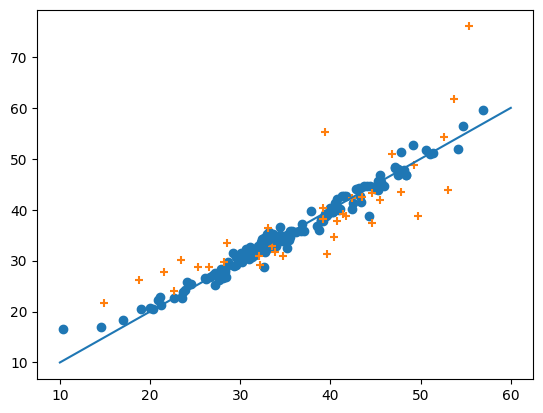

In [10]:
import pandas
import tensorflow as tf

### BEG DATA INTAKE
# read data file and confirm data shape
dataframe = pandas.read_csv('https://raw.githubusercontent.com/bryankolaczkowski/ALS3200C/main/phenopred.data.csv')
print(dataframe.shape)

# split into training and validation subsets, and confirm shape
train_dataframe = dataframe.sample(frac=0.8, random_state=402201)
valid_dataframe = dataframe.drop(train_dataframe.index)
print(train_dataframe.shape, valid_dataframe.shape, dataframe.shape)

# extract explanatory variables, convert to numpy and confirm shapes
snp_ids = [ x for x in dataframe.columns if x.find('SNP') == 0 ]
train_x = train_dataframe[snp_ids].to_numpy()
valid_x = valid_dataframe[snp_ids].to_numpy()
print(train_x.shape, valid_x.shape)

# extract response variables, convert to numpy and confirm shapes
train_y = train_dataframe['LS'].to_numpy()
valid_y = valid_dataframe['LS'].to_numpy()
print(train_y.shape, valid_y.shape)

# package into tensorflow.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x,valid_y)).batch(36)
### END DATA INTAKE

### BEG NEURAL NETWORK TRAIN-VALIDATE
## build and compile linear neural-network model
model = tf.keras.models.Sequential()
### BEG BUILD AND COMPILE MODEL
model.add(tf.keras.layers.InputLayer(input_shape=[17165]))
model.add(tf.keras.layers.Dropout(rate=0.9))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanAbsoluteError())
model.summary()


## fit and validate neural-network model
model.fit(train_data, epochs=500, validation_data=valid_data)
### END NEURAL NETWORK TRAIN-VALIDATE

### PLOT RESULTS FOR VISUALIZATION
## predict training and validation responses for plotting
train_y_hat = model.predict(train_x)
valid_y_hat = model.predict(valid_x)

## plot true-vs-predicted responses
import matplotlib.pyplot as plt
plt.plot([10,60],[10,60])
plt.scatter(train_y, train_y_hat, marker='o')
plt.scatter(valid_y, valid_y_hat, marker='+')

When I trained my model with 90% dropout after the *Input* layer, my model's final loss on the validation data was much more similar to its loss on the training data, suggesting that the model has *reduced* overfitting with dropout. Your specific loss values are probably going to vary somewhat, but you should observe that the final model's losses on the training and validation data sets are fairly similar.

You *might* find that the final model's validation loss is still *somewhat* higher than it's training-data loss (or the validation loss might be *lower*), but they should be more similar than you observed *without* using Dropout.

In my case, the plot of the validation data was inconclusive 'by eye'; the validation data were 'maybe spread out' a bit more than the training data, but it's difficult to tell with certainty from the plot, given the small amount of data in general.

## conclusions

So, what can we conclude from this exercise?

Based on our comparison of the training and validation losses for the *final* model, we don't see any *strong* evidence that our model is 'overfitting' the training data, so long as we use an extreme Dropout on the input layer and make sure the fitting process converges.

We did actually 'look at' the validation data, and then *changed* something about the model: we compared the validation loss to the training loss, and used that information to decide to include a Dropout layer on the input!

So we should *not* use this fitted model to predict responses from *new* data in practice, until we can "test" its expected accuracy using a *new* test data set. Ideally, we would have split our data using a 3-way train-validate-test split *at the very beginning*; we can't do it now, because we've already 'looked at' the data, so we'll need to go out and collect an 'entirely new' dataset experimentally, if we want to use our model for prediction.

In this case, we had a *very limited* amount of data samples (182 lines), compared to the 'complexity' of our neural network model (17,166 parameters). This is a very common problem in genome-sequence analyses. It costs money to sequence genomes, making it difficult to collect the *millions* of data samples needed to reliably train 'deep' neural networks.

In general, AI applications in the agricultural and life sciences tend to suffer from an extreme **data shortage**, compared to more traditional AI fields like image analysis and natural language processing. This makes the development of AI systems in agricultural and life sciences a bit more challenging. We can't just create 'arbitrarily large' neural networks, and then rely on *huge* training data sets to reliably fit the model and avoid overfitting.

In this case, our small data set precluded the use of a 3-way train-validate-test data split, so we can't use our model for phenotype predictions from *new* genomes.

We *can* argue, however that it appears a simple linear model 'fits' our data pretty well, with no obvious signature of overfitting.

So what does this say about the original data - the SNPs and their relationship to fly longevity?

Based only on 'looking at' the plotted data, it *appears* as if a simple additive model explains the relationship between genomic variation (as measured by these SNPs) and fly longevity in these inbread lines.

We can't be too 'certain' without fitting more-complex models and using model-selection procedures to identify the 'best-fit' model, but just 'by eye', there does not *appear* to be any *strong* evidence for epistatic or other non-linear interactions among these genetic variation 'markers' and fly longevity.

Based on this evidence, it 'appears' as if the genetic 'architecture' of fly longevity is likely to be 'additive': it is probably impacted by a *large number* of genes, each contributing a *little bit* to the overall phenotypic trait (in this case, how long the fly lives).

Identifying the *specific genes* that impact fly longevity is likely to be challenging, as the *impact* of each individual gene on the longevity-score value is likely to be *very* small and would require a *large number of lines* to detect using a Genome Wide Association Study (GWAS) or similar approach.

This is one of the major reasons why GWAS studies of complex human-disease phenotypes (Alzheimer's, Schizophrenia, Diabetes, etc) need to recruit *thousands* of subjects or more to detect disease-associated genes.

Using just a simple *linear* model, we were able to *identify* the additive genomic basis associated with a complex phenotypic trait from fewer than 200 'subjects', although we don't know 'which' specific genes are involved.